In [39]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
# Add libraries and functions
library(gsignal)
library(eyeris)
library(dplyr)
source("../../src/preprocessing/remove_gaze_regressor.R")
source("../../src/preprocessing/load_data.R")
source("../../src/preprocessing/add_nan_descriptors.R")
source("../../src/preprocessing/replace_out_of_bounds.R")


Attaching package: ‘gsignal’

The following objects are masked from ‘package:stats’:

    filter, gaussian, poly


Attaching package: ‘eyeris’

The following object is masked from ‘package:gsignal’:

    detrend


Attaching package: ‘dplyr’

The following object is masked from ‘package:gsignal’:

    filter

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


In [16]:
%%R
file <- "/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/sub-003_run-1.asc"
valid_subs <- c("sub-003")

# Load the data
loaded_data <- load_data(file, valid_subs)

# Make the data items available in the global environment
data <- loaded_data$data
subject_id <- loaded_data$subject_id
run_id <- loaded_data$run_id
subject_num <- loaded_data$subject_num
run_num <- loaded_data$run_num

[1] "Processing sub-003 run-1"


In [17]:
%%R
# (5) Remove the gaze regressor
data <- remove_gaze_regressor(data)
mean_pupil_size <- mean(data$timeseries$pupil_raw, na.rm = TRUE)
# (3) Replace out of bounds values with NA
data <- replace_out_of_bounds(data)

# (4) Add indicator variables for blink and out of bounds
data <- add_nan_descriptors(data)

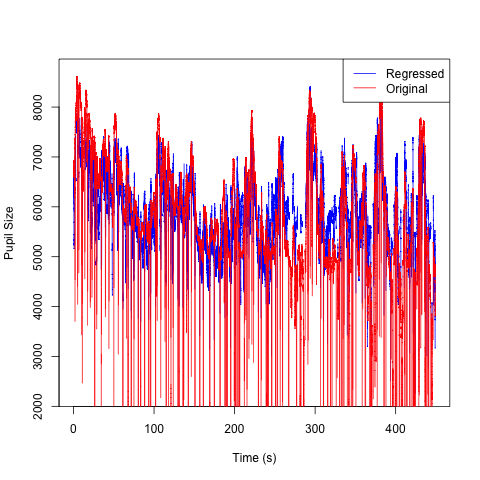

In [18]:
%%R
# Plot to compare how the data looks
time <- data$timeseries$time_orig
# convert to seconds, starting at 0
time <- (time - time[1]) / 1000

# plot pupil_raw and pupil_raw_orig
plot(time, data$timeseries$pupil_raw, type="l", col="blue", xlab="Time (s)", ylab="Pupil Size")
lines(time, data$timeseries$pupil_raw_orig, col="red")
legend("topright", legend=c("Regressed", "Original"), col=c("blue", "red"), lty=1)


In [19]:
%%R
eye_preproc <- eyeris::deblink(data, extend = 100) |> eyeris::detransient(n = 16) |> eyeris::interpolate() |> eyeris::lpfilt(wp = 0.02, ws = 0.04, rp = 1, rs = 35)

In [20]:
%%R
# Bandpass filter the data
fs <- eye_preproc$info$sample.rate
fpass <- c(0.02, 4)
wpass <- fpass / (fs / 2)
but <- gsignal::butter(2, wpass, "pass")
eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt <- gsignal::filtfilt(but, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate) + mean_pupil_size

In [21]:
%%R
# Define target sampling rate
target_hz <- 50
original_hz <- eye_preproc$info$sample.rate
resample_factor <- original_hz / target_hz

eye_preproc$timeseries <- eye_preproc$timeseries %>%
mutate(bin = ceiling(row_number() / resample_factor)) %>%
group_by(bin) %>%
summarise(
# Apply mean to specific columns
eye_x = mean(eye_x, na.rm = TRUE),
eye_y = mean(eye_y, na.rm = TRUE),


# Apply median to specific columns
pupil_raw = median(pupil_raw, na.rm = TRUE),
pupil_raw_deblink = median(pupil_raw_deblink, na.rm = TRUE),
pupil_raw_deblink_detransient = median(pupil_raw_deblink_detransient, na.rm = TRUE),
pupil_raw_deblink_detransient_interpolate = median(pupil_raw_deblink_detransient_interpolate, na.rm = TRUE),
pupil_raw_deblink_detransient_interpolate_lpfilt = median(pupil_raw_deblink_detransient_interpolate_lpfilt, na.rm = TRUE),
#pupil_raw_deblink_detransient_interpolate_lpfilt_detrend_poly = median(pupil_raw_deblink_detransient_interpolate_lpfilt_detrend_poly, na.rm = TRUE),

# Pick a single value (first row in each bin)
time_orig = first(time_orig),
eye = first(eye),
hz = first(hz),
type = first(type),
blink = first(blink),
outofbounds = first(outofbounds),

.groups = "drop"
)

eye_preproc$info$sample.rate <- 50
eye_preproc$timeseries$hz <- 50

In [22]:
%%R
# (9) Epoch the data and compute baseline pupil size for trials
eye_preproc <- eyeris::epoch(eye_preproc, events = "flag_TrialStart*", calc_baseline = TRUE, apply_baseline = FALSE, baseline_events = "flag_TrialStart*", baseline_period = c(-0.5, 0), limits = c(0, 4))
eye_preproc <- eyeris::epoch(eye_preproc, events = "flag_Response*", calc_baseline = FALSE, apply_baseline = FALSE, limits = c(-1.5, 1.5))
eye_preproc$epoch_flagTrialstart$trial <- as.numeric(gsub(".*_Trial(\\d+)_.*", "\\1", eye_preproc$epoch_flagTrialstart$matched_event))
eye_preproc$epoch_flagResponse$trial <- as.numeric(gsub(".*_Trial(\\d+)_.*", "\\1", eye_preproc$epoch_flagResponse$matched_event))

In [23]:
%%R
eye_preproc$epoch_flagTrialstart$baseline <- eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch[eye_preproc$epoch_flagTrialstart$trial]
eye_preproc$epoch_flagResponse$baseline <- eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch[eye_preproc$epoch_flagResponse$trial]
eye_preproc$epoch_flagTrialstart$ps_preprocessed <- (eye_preproc$epoch_flagTrialstart$pupil_raw_deblink_detransient_interpolate_lpfilt - eye_preproc$epoch_flagTrialstart$baseline) / (eye_preproc$epoch_flagTrialstart$baseline + mean_pupil_size)
eye_preproc$epoch_flagResponse$ps_preprocessed <- (eye_preproc$epoch_flagResponse$pupil_raw_deblink_detransient_interpolate_lpfilt - eye_preproc$epoch_flagResponse$baseline) / (eye_preproc$epoch_flagResponse$baseline + mean_pupil_size)

In [24]:
%%R
eye_preproc$epoch_flagTrialstart$sub <- subject_num
eye_preproc$epoch_flagResponse$sub <- subject_num
eye_preproc$epoch_flagTrialstart$trial <- eye_preproc$epoch_flagTrialstart$trial + (run_num-1) * 64
eye_preproc$epoch_flagResponse$trial <- eye_preproc$epoch_flagResponse$trial + (run_num-1) * 64


# (10) Select the relevant columns to save
output_data <- eye_preproc$epoch_flagTrialstart %>%
    select(sub, timebin, trial, ps_preprocessed, blink, outofbounds)

output_data2 <- eye_preproc$epoch_flagResponse %>%
    select(sub, timebin, trial, ps_preprocessed, blink, outofbounds)

In [32]:
%%R
data_summary <- output_data %>%
  group_by(trial) %>%
  summarise(mean_blink = mean(blink, na.rm = TRUE)) %>%
  filter(mean_blink <= 0.5) %>%
  select(trial)

filtered_data <- output_data %>%
  semi_join(data_summary, by = "trial")

In [36]:
%%R
filtered_summary <- filtered_data %>%
  group_by(timebin) %>%
  summarise(mean_ps = mean(ps_preprocessed, na.rm = TRUE))